In [3]:
import shutil
from PIL import Image, ImageChops, ImageMath
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

## Goal: Pass Fake, Black Funduses Into Segmentation Model

Here's how I'm going to do it: 

1. Load images from GAN results into segmentation DeepROP dataset folder. There are already some images here. I can keep them, that shouldn't be an issue because I'll load in with these ids. Output will rewrite.
2.  Run segmentation model separately... then receive output in output folder, which will be here. Very neat because of all these wonderful mounts :)
3. Now I have output! I can built a cool graphic with this information.


XX 2. In this copying step, I've also got to resize the images. So that they are 640 x 480 instead of 256 x 256. I'd like them to be resized so we can compare more thoroughly with what happening in original (and resizing should cause no trouble, will it?) XX scaling and cropping -- too complicated for unnecessary task

### Copy images from GAN results into segmentation DeepROP dataset folder

In [4]:
white_test_ids = ['96618','56548','99901','84606','18172','24576','59419','74682','30792','51485','79737','77014','24577',
                  '16788','84965','103039','79741','84994','52444','103078','79473','18171','81848','85641','47077']

In [5]:
gan_results_path = "/users/riya/race/gancode/pytorch-CycleGAN-and-pix2pix/results/edges2shoes/test_latest/images/"
segmentation_input_path = "/users/riya/race/segmentation_run/DeepROP/dataset/"
segmentation_output_path = "/users/riya/race/segmentation_run/DeepROP/output/segmentation/"

In [4]:
def copy_images(ids, path_input, path_copy):
    for i in ids:
        fund_fake_image = Image.open(path_input + i + "_fake_B" + ".png")
        fund_fake_image.save(path_copy + i + "_fake_fundus" + ".png")

In [32]:
copy_images(white_test_ids, gan_results_path, segmentation_input_path)

In [6]:
len(white_test_ids)

25

In [7]:
len(os.listdir(segmentation_input_path)) # grt! All done

25

### Running Segmentation Model



Do resize automatically! I only resized a small percentage of images (314 in total) and used Antialias. Seems Bicubic is preferred. Anyway, I'll use the same resize function when resizing the images from the results folder for my graphic and comparison.

(height, width) = (480, 640)

### Output Graphic - all 4 Images side-by-side

In [8]:
def generate_output_images(arr_ids, path1, path2): # path 1: gan results, path 2: segmentation on fake fundus
    
    size_tuple = (640, 480) # width, height
    
    for i in arr_ids:
        seg_img = Image.open(path1 + i + "_real_A" + ".png").resize(size_tuple, Image.BICUBIC)
        
        # mpimg.imread(path + i + "_real_A" + ".png")
        
        fund_real_img = Image.open(path1 + i + "_real_B" + ".png").resize(size_tuple, Image.BICUBIC)
        # mpimg.imread(path + i + "_real_B" + ".png")
        
        fund_fake_img = Image.open(path1 + i + "_fake_B" + ".png").resize(size_tuple, Image.BICUBIC)
        # fund_fake_img = mpimg.imread(path + i + "_fake_B" + ".png")
        
        seg_fake_img = Image.open(path2 + i + "_fake_fundus" + ".bmp") ## these are bmps! already resized, no need to do that.
        
        # generate 4 x 1 plot
        
        f, axarr = plt.subplots(1,4)
        f.suptitle(i)
        axarr[0].imshow(seg_img)
        axarr[1].imshow(fund_real_img)
        axarr[2].imshow(fund_fake_img)
        axarr[3].imshow(seg_fake_img, cmap='gray')
        
        if i == '59419':
            f, axarr = plt.subplots(1,4, figsize = (320, 240))
            f.suptitle(i)
            axarr[0].imshow(seg_img)
            axarr[1].imshow(fund_real_img)
            axarr[2].imshow(fund_fake_img)
            axarr[3].imshow(seg_fake_img, cmap='gray')

The only issue with resizing is really with the fact that the images were cropped at all when first fed into the model. Since they were cropped, now resizing doesn't maintain that ratio. Acutally wait it does! since they were scaled into square shape then cropped into square shape. It's just that we're missing some part of the segmentation of the image since it got cut. I probably should have set no crop at all.... will I have to retrain? I hope not, although I did lose some of the image information. We can consider the information I did have by performing a crop on the original segmentation too - basically just using the one we fed into the model, which was scaled/cropped as described. That should be okay??

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


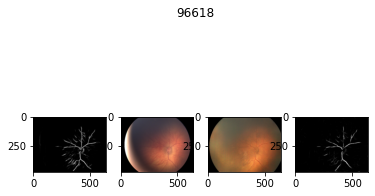

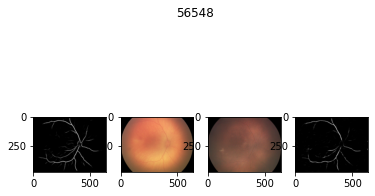

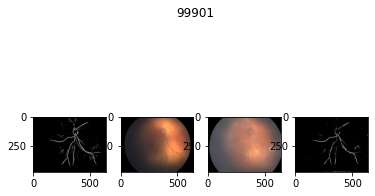

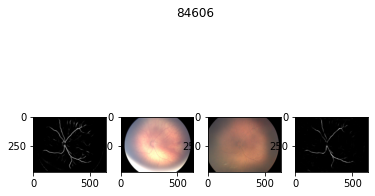

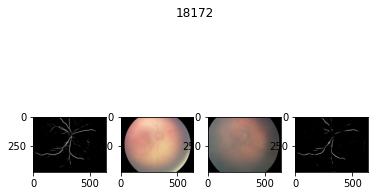

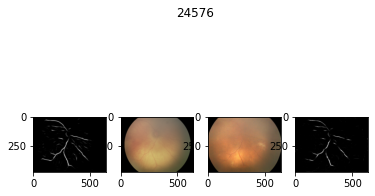

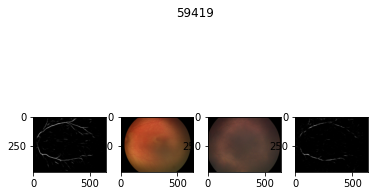

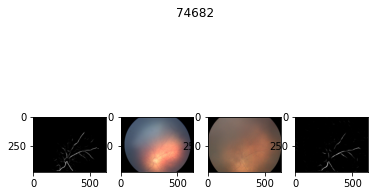

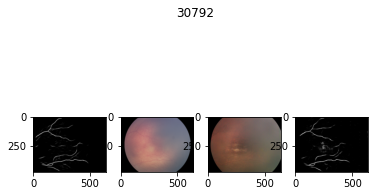

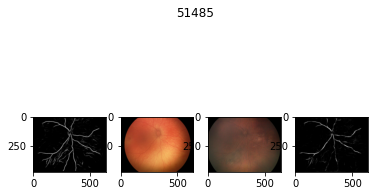

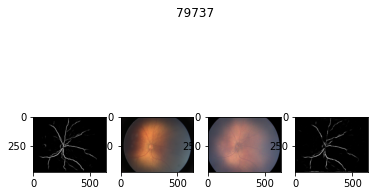

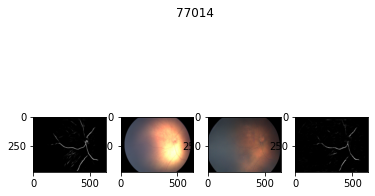

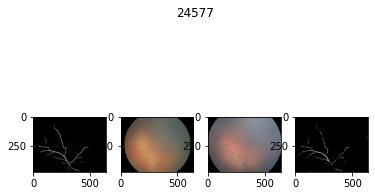

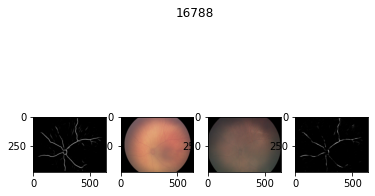

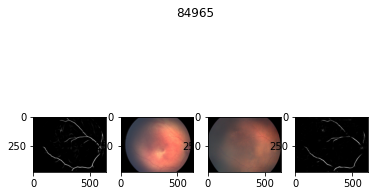

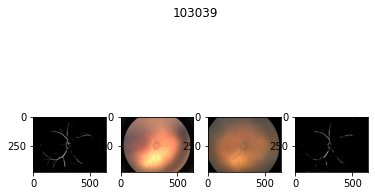

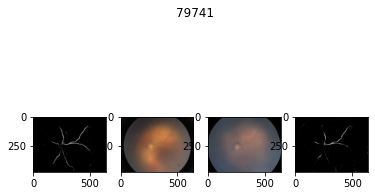

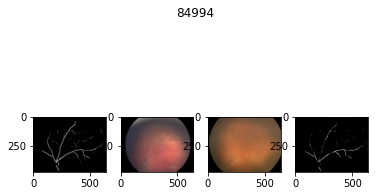

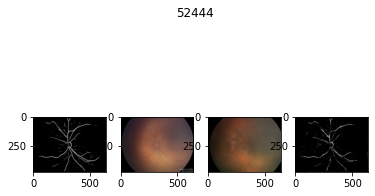

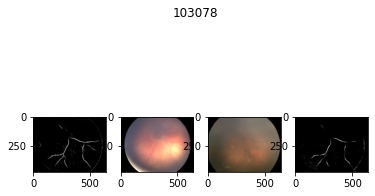

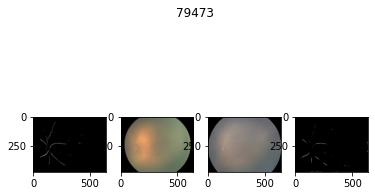

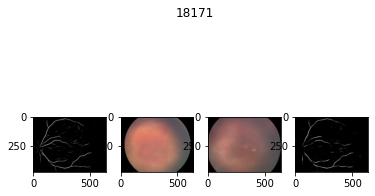

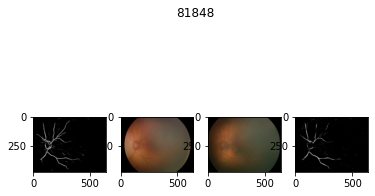

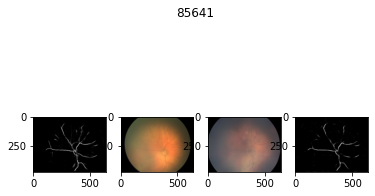

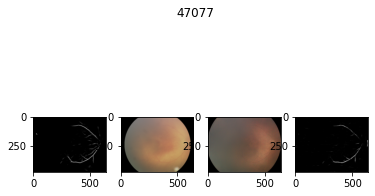

In [10]:
generate_output_images(white_test_ids, gan_results_path, segmentation_output_path)

### Difference Images

I also want to get average pixel values here... that will be helpful in comparisons with fake segmentations predicted black. I'll go through and do that.

In [12]:
# the total pixel values in image summed divided by the number of nonzero pixels in the difference image

def get_diff_score(img):
    score_img = np.array(img)
    num_nonzero = np.count_nonzero(score_img)
    diff_score = score_img.sum()/num_nonzero
    
    return diff_score

In [23]:
diff_score_arr = []
avg_pixel_real = []
avg_pixel_fake = []
nonzero_cnt_real = []
nonzero_cnt_fake = []

def generate_difference_maps(arr_ids, path1, path2, crop): # crop is boolean, either crop or no crop. crop if no_crop fails.
    
    size_tuple = (640, 480)
    
    for i in arr_ids:
        

        seg_img = Image.open(path1 + i + "_real_A" + ".png")
        if crop == True:
            seg_img = seg_img.resize((286, 286), Image.BICUBIC).crop((15, 15, 286-15, 286-15)) # random crop...
        
        seg_img = seg_img.resize(size_tuple, Image.BICUBIC).convert('L')
        seg_fake_img = Image.open(path2 + i + "_fake_fundus" + ".bmp") # size (640,480) because of segmentation model, but has been cropped
        
        # print(seg_img.size, seg_fake_img.size)
        # print(seg_img.mode, seg_fake_img.mode)
        
        diff_img = ImageChops.difference(seg_img, seg_fake_img) # absolute value, yay
        
        print(i)
        diff_plot = plt.imshow(diff_img, cmap='gray')
        
        # new!
        diff_score = get_diff_score(diff_img)
        print(diff_score)
        diff_score_arr.append(diff_score)
        
        avg_pixel_real_score = np.mean(np.array(seg_img))
        # avg_pixel_real_score = np.sum(np.array(seg_img))/np.count_nonzero(np.array(seg_img))
        print("avg pixel value real", avg_pixel_real_score)
        avg_pixel_real.append(avg_pixel_real_score)
        
        avg_pixel_fake_score = np.mean(np.array(seg_fake_img))
        # avg_pixel_fake_score = np.sum(np.array(seg_fake_img))/np.count_nonzero(np.array(seg_fake_img))
        print("avg pixel value fake", avg_pixel_fake_score)
        avg_pixel_fake.append(avg_pixel_fake_score)
        
        nonzero_cnt_real_score = np.count_nonzero(np.array(seg_img))
        print("count nonzero real", nonzero_cnt_real_score)
        nonzero_cnt_real.append(nonzero_cnt_real_score)
              
        nonzero_cnt_fake_score = np.count_nonzero(np.array(seg_fake_img))
        print("count nonzero fake", nonzero_cnt_fake_score)
        nonzero_cnt_fake.append(nonzero_cnt_fake_score)

        plt.show(diff_img)
    

96618
10.284046260943523
avg pixel value real 5.881780598958334
avg pixel value fake 3.8838346354166666
count nonzero real 59068
count nonzero fake 87853


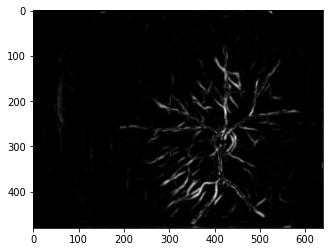

56548
9.776964420818882
avg pixel value real 6.014602864583333
avg pixel value fake 4.168486328125
count nonzero real 55021
count nonzero fake 82198


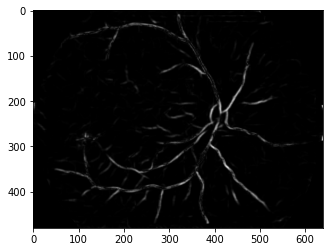

99901
11.114353521928992
avg pixel value real 6.503779296875
avg pixel value fake 4.463688151041667
count nonzero real 59209
count nonzero fake 86872


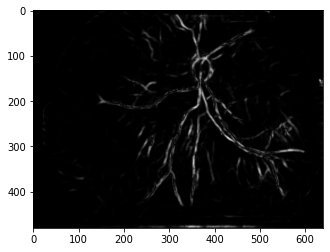

84606
9.482236854698238
avg pixel value real 5.176223958333333
avg pixel value fake 3.145419921875
count nonzero real 65531
count nonzero fake 73538


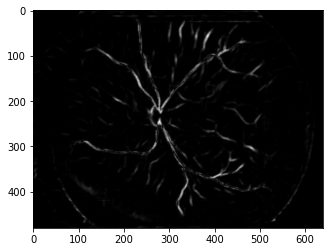

18172
10.602890217640821
avg pixel value real 5.403216145833333
avg pixel value fake 3.346285807291667
count nonzero real 53487
count nonzero fake 67982


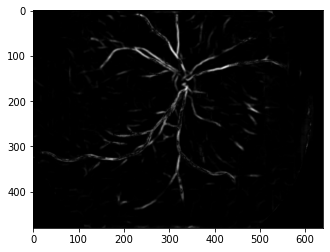

24576
8.925259419455964
avg pixel value real 4.968421223958333
avg pixel value fake 3.341376953125
count nonzero real 54744
count nonzero fake 79660


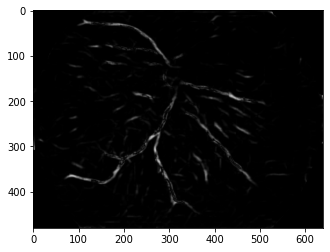

59419
8.576770470121438
avg pixel value real 4.288736979166667
avg pixel value fake 2.2263118489583333
count nonzero real 75691
count nonzero fake 90087


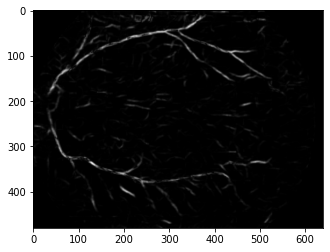

74682
7.612395788185504
avg pixel value real 3.0255533854166665
avg pixel value fake 2.3653580729166666
count nonzero real 37055
count nonzero fake 62712


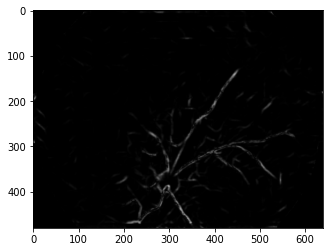

30792
9.017928124426687
avg pixel value real 4.987740885416667
avg pixel value fake 4.916910807291667
count nonzero real 53167
count nonzero fake 82759


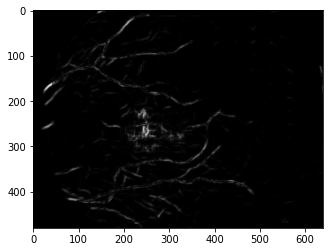

51485
11.877639208722915
avg pixel value real 8.8209375
avg pixel value fake 5.263779296875
count nonzero real 92239
count nonzero fake 114288


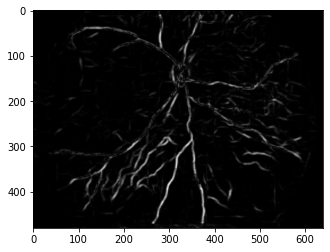

79737
10.708950505312258
avg pixel value real 6.428541666666667
avg pixel value fake 5.42705078125
count nonzero real 49755
count nonzero fake 82886


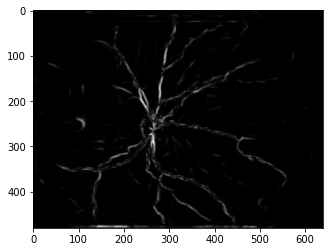

77014
7.096678201362839
avg pixel value real 3.487451171875
avg pixel value fake 2.80904296875
count nonzero real 44235
count nonzero fake 89515


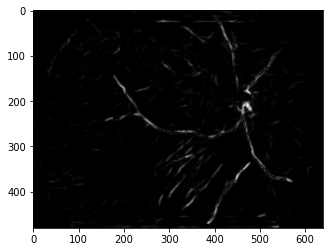

24577
8.48665506625619
avg pixel value real 4.01951171875
avg pixel value fake 3.28392578125
count nonzero real 36202
count nonzero fake 61758


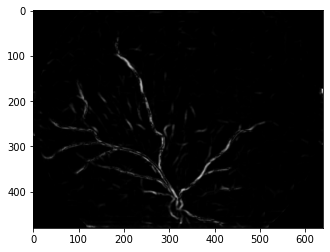

16788
10.63519215788107
avg pixel value real 5.016917317708334
avg pixel value fake 2.997688802083333
count nonzero real 49161
count nonzero fake 72293


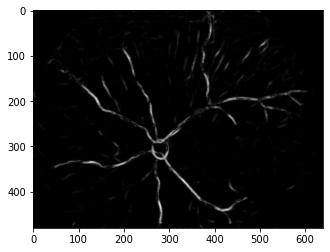

84965
8.556087368063865
avg pixel value real 5.557249348958333
avg pixel value fake 4.005966796875
count nonzero real 63329
count nonzero fake 87355


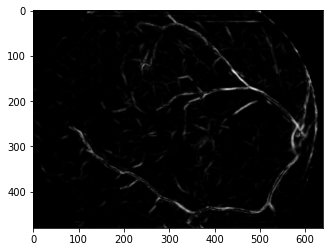

103039
7.616515983907947
avg pixel value real 3.5380078125
avg pixel value fake 2.6264583333333333
count nonzero real 46694
count nonzero fake 74039


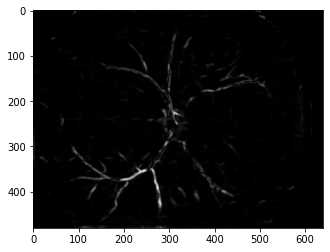

79741
7.946672891620953
avg pixel value real 3.0198567708333335
avg pixel value fake 2.34537109375
count nonzero real 28303
count nonzero fake 68060


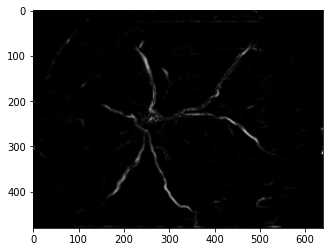

84994
10.958821647134114
avg pixel value real 5.50078125
avg pixel value fake 3.4943815104166664
count nonzero real 56104
count nonzero fake 75798


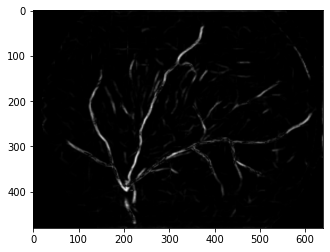

52444
11.90036906103104
avg pixel value real 8.23693359375
avg pixel value fake 5.699514973958333
count nonzero real 70493
count nonzero fake 111088


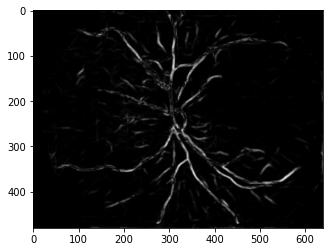

103078
8.800229045880753
avg pixel value real 4.369560546875
avg pixel value fake 2.872666015625
count nonzero real 56687
count nonzero fake 75202


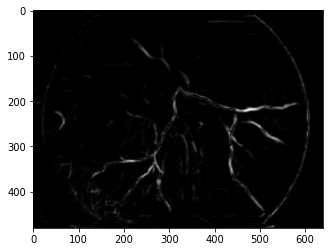

79473
7.508497047125467
avg pixel value real 1.4598372395833332
avg pixel value fake 1.1559244791666667
count nonzero real 22087
count nonzero fake 47015


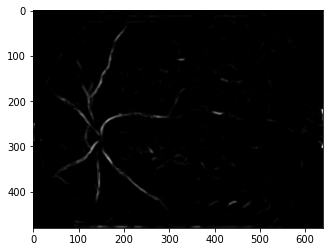

18171
9.141888647755863
avg pixel value real 5.971087239583333
avg pixel value fake 4.7341796875
count nonzero real 64229
count nonzero fake 80005


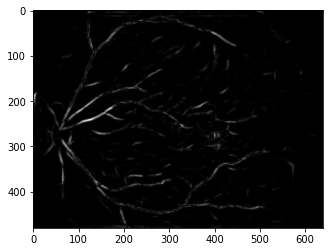

81848
9.507082152974505
avg pixel value real 5.674208984375
avg pixel value fake 4.075810546875
count nonzero real 56282
count nonzero fake 93211


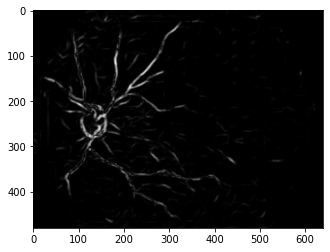

85641
8.435783870437357
avg pixel value real 4.847965494791667
avg pixel value fake 3.6955533854166664
count nonzero real 50188
count nonzero fake 78301


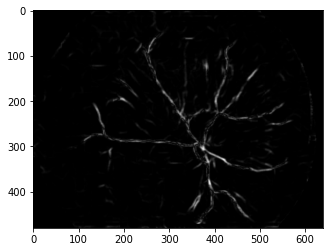

47077
8.67141946902655
avg pixel value real 2.8335970052083335
avg pixel value fake 1.9379036458333334
count nonzero real 30852
count nonzero fake 58885


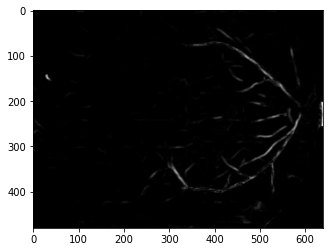

In [24]:
generate_difference_maps(white_test_ids, gan_results_path, segmentation_output_path, False)

In [15]:
np.mean(diff_score_arr)

9.32965309610855

In [22]:
np.mean(avg_pixel_real), np.mean(avg_pixel_fake)

(28.863220501960267, 13.500022557413516)

In [26]:
np.median(nonzero_cnt_real), np.median(nonzero_cnt_fake)

(54744.0, 79660.0)

In [ ]:
generate_difference_maps(white_test_ids, gan_results_path, segmentation_output_path, True)

# unnecessary, output more separated!

hmm, appears like crop is not an issue? have all images been cropped with the same randomness? YEEEEESS

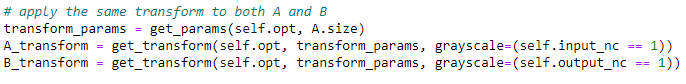

### Overlay Images - Addition

In [163]:
def overlay_cv(arr_ids, path1, path2):
    
    size_tuple = (640, 480)
    
    for i in arr_ids:   

        seg_img = cv2.imread(path1 + i + "_real_A" + ".png")
        seg_img = cv2.resize(seg_img, size_tuple, cv2.INTER_CUBIC)
        seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2GRAY)
        
        seg_fake_img = cv2.imread(path2 + i + "_fake_fundus" + ".bmp") # size (640,480) because of segmentation model, but has been cropped
        seg_fake_img = cv2.cvtColor(seg_fake_img, cv2.COLOR_BGR2GRAY)

        overlay_img = cv2.addWeighted(seg_img, 1, seg_fake_img,1, 0)
        # print(seg_img.size, seg_fake_img.size)
        # print(seg_img.mode, seg_fake_img.mode)
            
        print(i)
        diff_plot = plt.imshow(overlay_img, cmap='gray')   
        plt.show(diff_plot)

96618


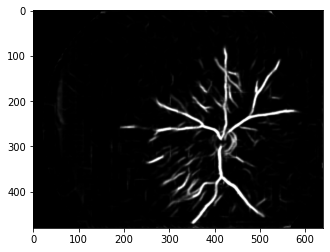

56548


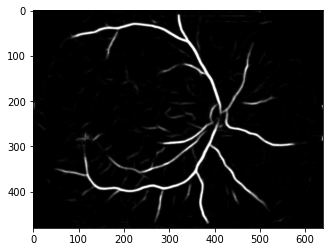

99901


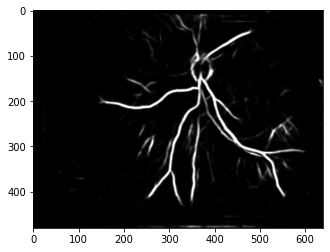

84606


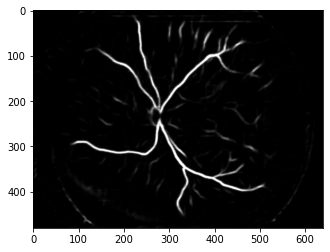

18172


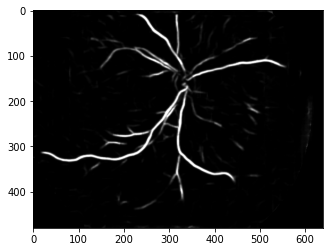

24576


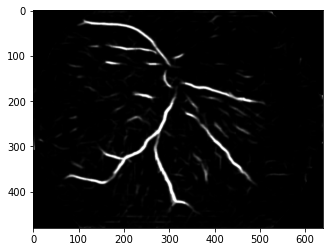

59419


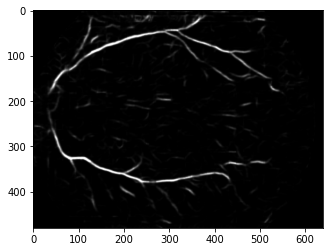

74682


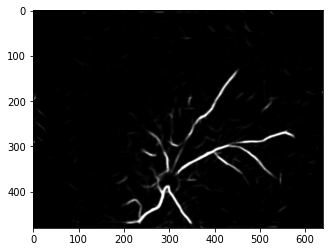

30792


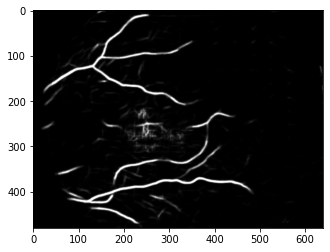

51485


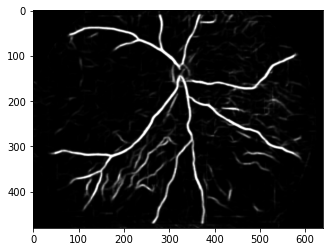

79737


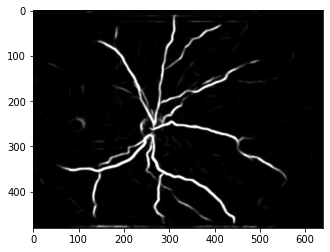

77014


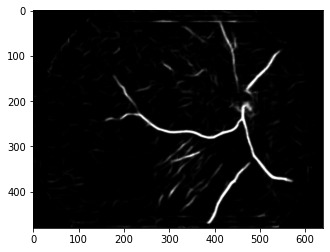

24577


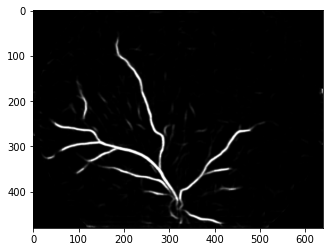

16788


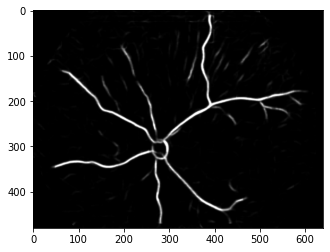

84965


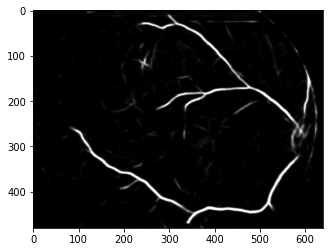

103039


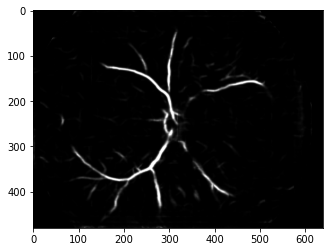

79741


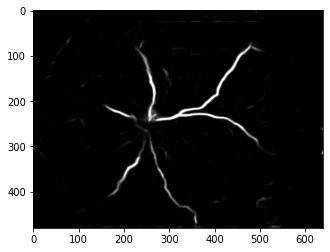

84994


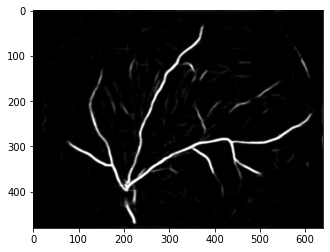

52444


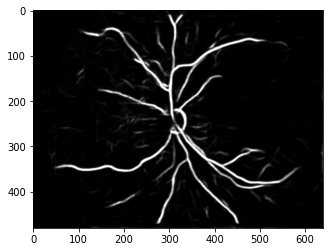

103078


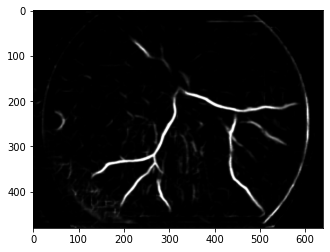

79473


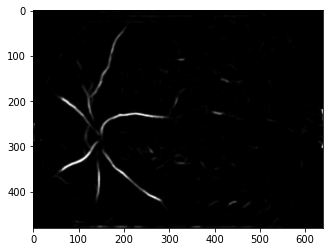

18171


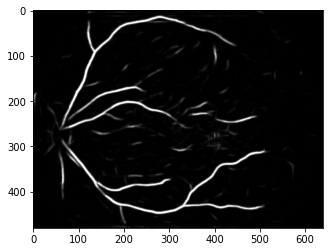

81848


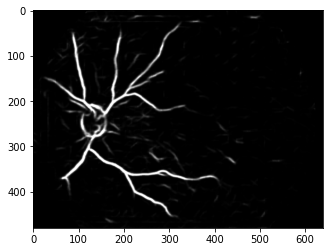

85641


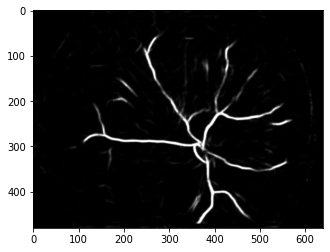

47077


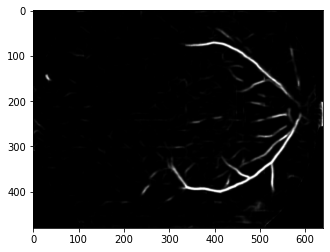

In [164]:
overlay_cv(white_test_ids, gan_results_path, segmentation_output_path)

In [102]:
# also, lets't try just overlaying the images, before we run the model hopefully! :)

def overlay_old(arr_ids, path1, path2):
    
    size_tuple = (640, 480)
    
    for i in arr_ids:   

        seg_img = Image.open(path1 + i + "_real_A" + ".png").resize(size_tuple, Image.BICUBIC).convert('L')
        seg_fake_img = Image.open(path2 + i + "_fake_fundus" + ".bmp") # size (640,480) because of segmentation model, but has been cropped
        
        # print(seg_img.size, seg_fake_img.size)
        # print(seg_img.mode, seg_fake_img.mode)
                
        seg_img.paste(seg_fake_img, mask = seg_fake_img) # updates seg_img automatically, no need to equate
            
        print(i)
        diff_plot = plt.imshow(seg_img, cmap='gray')   
        plt.show(diff_plot)

overlay_old(white_test_ids, gan_results_path, segmentation_output_path)